## 패키지

In [1]:
import warnings
warnings.filterwarnings('ignore')
from pandas import DataFrame,read_csv,read_excel,merge,melt,pivot_table
import numpy
from matplotlib import pyplot as plt
import seaborn as sb
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer.factor_analyzer import calculate_kmo

import numpy as np
import helper
from math import sqrt
from scipy.stats import shapiro, normaltest, ks_2samp
from scipy.stats import bartlett, fligner, levene, chi2_contingency,t
from sklearn.decomposition import PCA #주성분 분석용 패키지
from pca import pca # 주성분 분석 결과를 DataFrame으로 확인할 수 있는 기능을 제공하는 패키지

## 폰트

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.unicode_minus"] = False

### 데이터 불러오기

In [3]:
origin=read_excel('행정동병합테스트22_최종데이터.xlsx')
origin.head()

,시도명,시군구코드,시군구명,행정동코드,행정동코드수정,읍면동명,생성일자,말소일자,지하철역수,의료기관수,...,주차장개소,주차장면수,하천및한강여부,아동인구,노인인구,장애인인구,세대당공원면적,교통약자지수,시민문화지수,접근성지수
0,서울특별시,11110,종로구,1111051500,11110515,청운효자동,20081101,NaN,NaN,11.0,...,668,4592,무,612.0,2154,437,337.55,0.883757,12.240301,0.978054
1,서울특별시,11110,종로구,1111053000,11110530,사직동,19880423,NaN,2.0,75.0,...,362,12605,무,488.0,1808,267,60.79,0.952852,35.399526,2.354708
2,서울특별시,11110,종로구,1111054000,11110540,삼청동,19880423,NaN,NaN,11.0,...,343,2237,무,108.0,626,110,956.51,0.715943,39.839834,2.266277
3,서울특별시,11110,종로구,1111055000,11110550,부암동,19880423,NaN,NaN,4.0,...,596,3533,유,385.0,1814,311,0.00,0.710363,5.777047,1.081284
4,서울특별시,11110,종로구,1111056000,11110560,평창동,19880423,NaN,NaN,15.0,...,1617,9390,유,1033.0,3495,491,1.14,0.714284,2.630924,1.576024


## 데이터 복사

In [4]:
df = origin.copy()

### 데이터 타입 및 이상치, 결측치 확인

In [5]:
df.dtypes

시도명         object
시군구코드        int64
시군구명        object
행정동코드        int64
행정동코드수정      int64
읍면동명        object
생성일자         int64
말소일자       float64
지하철역수      float64
의료기관수      float64
사회복지시설수    float64
계(명)         int64
면적         float64
구성비        float64
행정동별공원수    float64
공공체육시설수    float64
문화시설수      float64
학교수        float64
사업체수       float64
보육시설         int64
주차장개소        int64
주차장면수        int64
하천및한강여부     object
아동인구       float64
노인인구         int64
장애인인구        int64
세대당공원면적    float64
교통약자지수     float64
시민문화지수     float64
접근성지수      float64
dtype: object

In [6]:
df.isna().sum()

시도명          0
시군구코드        0
시군구명         0
행정동코드        0
행정동코드수정      0
읍면동명         0
생성일자         0
말소일자       426
지하철역수      222
의료기관수        5
사회복지시설수     29
계(명)         0
면적           0
구성비          0
행정동별공원수    317
공공체육시설수    139
문화시설수      182
학교수         35
사업체수         5
보육시설         0
주차장개소        0
주차장면수        0
하천및한강여부      0
아동인구         2
노인인구         0
장애인인구        0
세대당공원면적      3
교통약자지수       0
시민문화지수       0
접근성지수        0
dtype: int64

In [11]:
df = df.fillna(0)
df.isna().sum()

시도명        0
시군구코드      0
시군구명       0
행정동코드      0
행정동코드수정    0
읍면동명       0
생성일자       0
말소일자       0
지하철역수      0
의료기관수      0
사회복지시설수    0
계(명)       0
면적         0
구성비        0
행정동별공원수    0
공공체육시설수    0
문화시설수      0
학교수        0
사업체수       0
보육시설       0
주차장개소      0
주차장면수      0
하천및한강여부    0
아동인구       0
노인인구       0
장애인인구      0
세대당공원면적    0
교통약자지수     0
시민문화지수     0
접근성지수      0
dtype: int64

In [12]:
results = []
for column in df.columns:
    zero_count = df.loc[df[column] == 0].shape[0]
    number_count = df.loc[df[column] != 0].shape[0]
    results.append({
        '변수': column,
        '0 값인 수': zero_count,
        '0 값이 아닌 수': number_count
    })
result_df = DataFrame(results)
result_df

,변수,0 값인 수,0 값이 아닌 수
0,시도명,0,426
1,시군구코드,0,426
2,시군구명,0,426
3,행정동코드,0,426
4,행정동코드수정,0,426
5,읍면동명,0,426
6,생성일자,0,426
7,말소일자,426,0
8,지하철역수,222,204
9,의료기관수,5,421


> 0값이 0이 아닌 값보다 많은 변수는 존재하지만 실제 조사 데이터이고, 최종적으로는 군집(clustering)을 사용할 계획이므로 정상 값으로 판단.

## 기초통계량 확인


In [13]:
df.describe()

,시군구코드,행정동코드,행정동코드수정,생성일자,말소일자,지하철역수,의료기관수,사회복지시설수,계(명),면적,...,보육시설,주차장개소,주차장면수,아동인구,노인인구,장애인인구,세대당공원면적,교통약자지수,시민문화지수,접근성지수
count,426.000000,4.260000e+02,4.260000e+02,4.260000e+02,426.0,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,11433.521127,1.143415e+09,1.143415e+07,1.993527e+07,0.0,0.741784,40.147887,5.784038,22674.464789,1.420751,...,11.061033,720.028169,10567.781690,1245.509390,3914.110329,919.823944,23.567394,0.662883,-8.522392,0.917244
std,192.086184,1.920776e+07,1.920776e+05,8.838731e+04,0.0,0.991251,47.293071,4.523958,9061.737866,1.569773,...,6.360617,527.175416,7181.650766,776.382717,1595.727172,490.468568,91.821912,0.679175,41.402293,0.854417
min,11110.000000,1.111052e+09,1.111052e+07,1.988042e+07,0.0,0.000000,0.000000,0.000000,70.000000,0.230000,...,0.000000,9.000000,193.000000,0.000000,11.000000,3.000000,0.000000,0.000000,-412.309661,0.000000
25%,11260.000000,1.126066e+09,1.126066e+07,1.988042e+07,0.0,0.000000,18.000000,2.000000,16703.500000,0.670000,...,7.000000,299.000000,6102.500000,717.250000,2844.750000,560.500000,0.280000,0.476864,-17.599562,0.433648
50%,11440.000000,1.144064e+09,1.144064e+07,1.988042e+07,0.0,0.000000,31.000000,5.000000,21978.500000,0.975000,...,10.000000,619.000000,8621.500000,1061.500000,3717.000000,812.000000,1.105000,0.592635,-5.494856,0.768573
75%,11612.500000,1.161306e+09,1.161306e+07,1.995030e+07,0.0,1.000000,48.000000,8.000000,27909.750000,1.490000,...,14.000000,1066.250000,13132.500000,1594.750000,4842.750000,1215.500000,6.737500,0.727934,2.547224,1.139003
max,11740.000000,1.174070e+09,1.174070e+07,2.022122e+07,0.0,7.000000,640.000000,27.000000,54896.000000,12.680000,...,39.000000,3162.000000,53019.000000,6505.000000,8750.000000,3649.000000,956.510000,12.920349,357.609180,9.733274


In [14]:
df1 = df.copy()
df1 = df1.drop(['시도명','시군구코드','시군구명','행정동코드','읍면동명', '말소일자'],axis=1)
df1.columns

Index(['행정동코드수정', '생성일자', '지하철역수', '의료기관수', '사회복지시설수', '계(명)', '면적', '구성비',
       '행정동별공원수', '공공체육시설수', '문화시설수', '학교수', '사업체수', '보육시설', '주차장개소', '주차장면수',
       '하천및한강여부', '아동인구', '노인인구', '장애인인구', '세대당공원면적', '교통약자지수', '시민문화지수',
       '접근성지수'],
      dtype='object')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

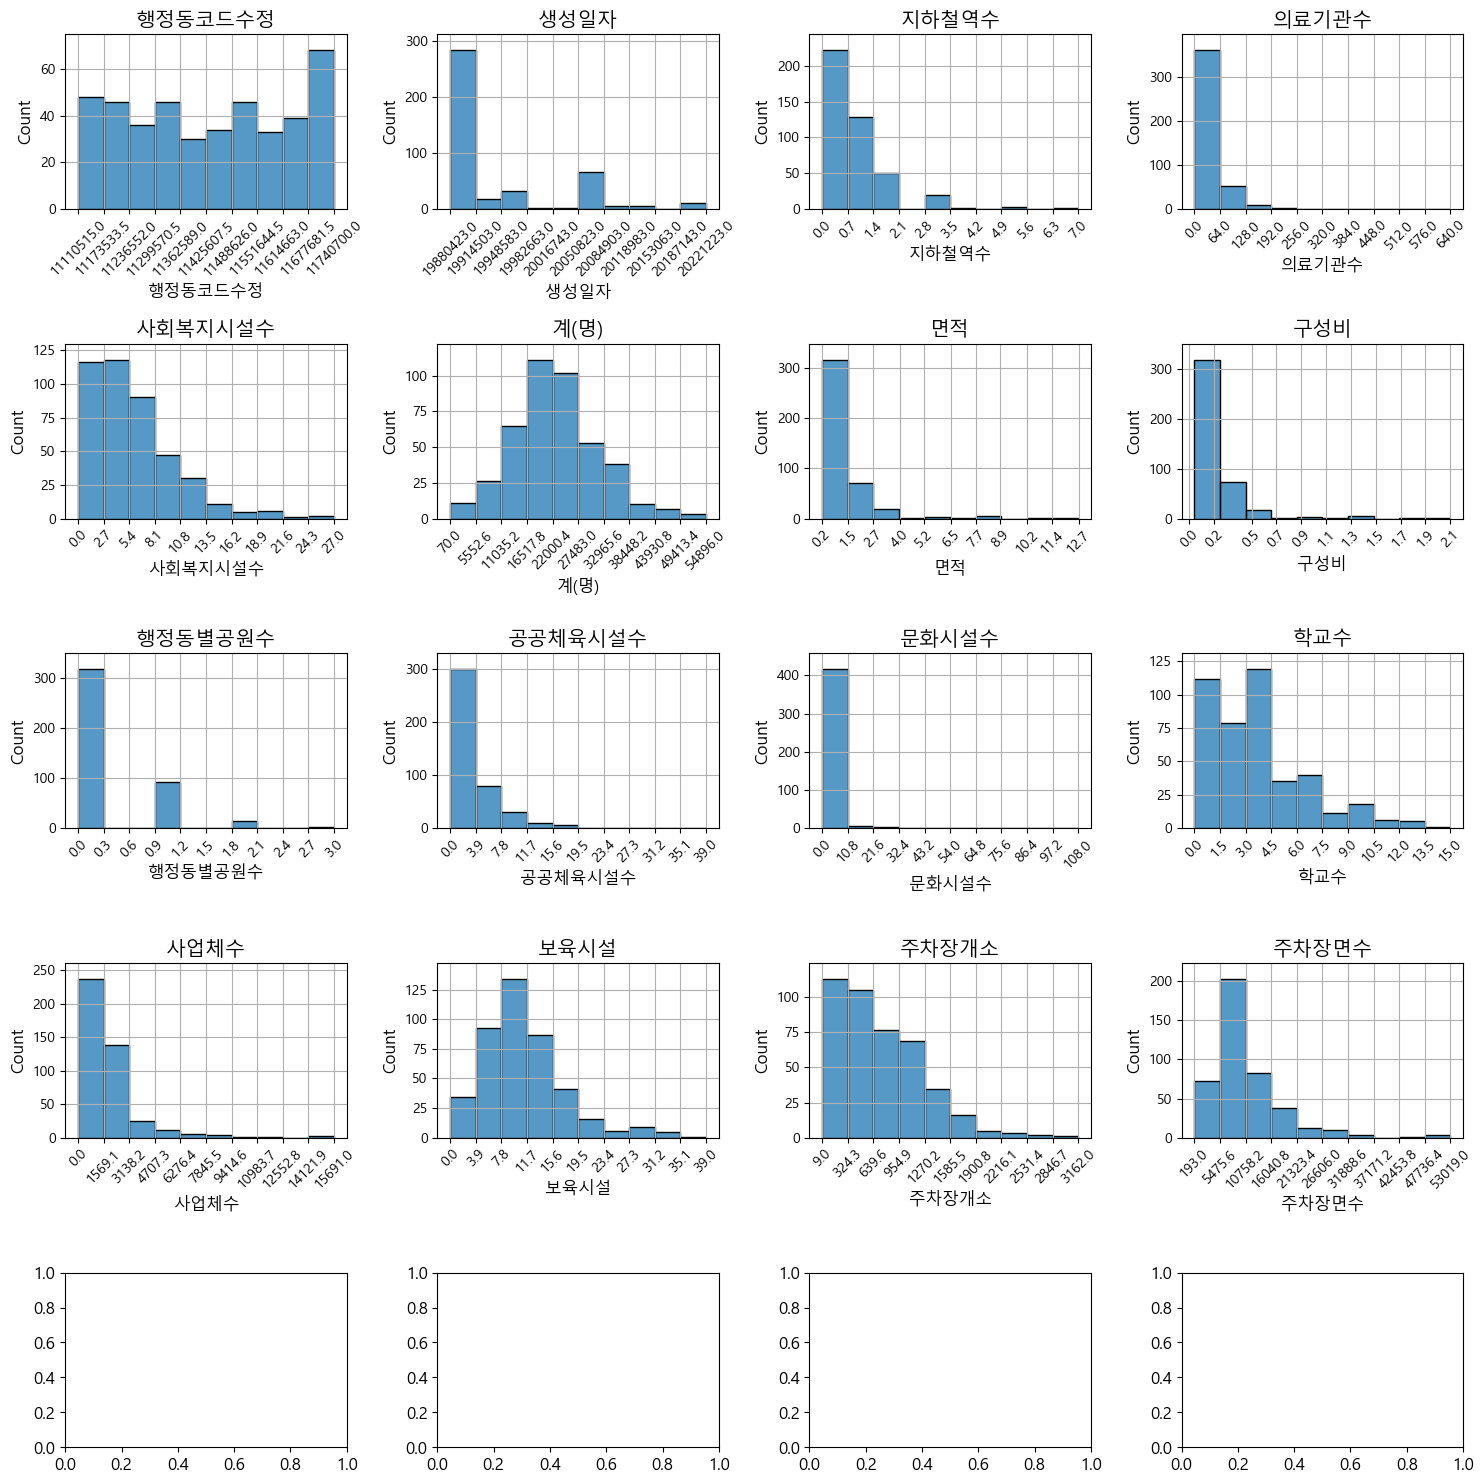

In [16]:
# 이상치 확인 전
# 데이터를 정리해서 볼 수 있도록 도수분포표(히스토그램) 확인

# 히스토그램과 bins(구간) 설정
num_bins = 10 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))  # 5x3 서브플롯 생성

for ax, column in zip(axes.flat, df1.columns):
    hist, bins = np.histogram(df1[column], bins=num_bins)
    bins2 = np.round(bins, 1)

    sb.histplot(data=df1, x=column, bins=num_bins, kde=False, ax=ax) #확률밀도곡선 미표시(티가 안 남)
    ax.set_title(column)  # 각 subplot의 제목 설정
    ax.set_xticks(bins2)  # x축 눈금 설정
    ax.set_xticklabels(bins2, rotation=45, fontsize=10)  # x축 눈금 라벨(각도 45도), 폰트 설정
    ax.yaxis.set_tick_params(labelsize=10) #y축 폰트 설정

    # y축 범위 설정(여유 범위를 넣어야 가독성이 좋아짐)
    y_max = hist.max() + hist.max() * 0.1  # 최대 도수에 10% 여유를 더한 값으로 y축 최댓값 설정
    ax.set_ylim(0, y_max)  # y축 범위 설정
    ax.grid(True) # 격자 표시
    plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

## 이상치 확인

### 반복문과 sub plot을 이용해 regplot 조회

> 역세권이 중요한 만큼 '행정동내_지하철역_수'를 종속변수로

In [11]:
df1.columns

Index(['면적', '서울시전체면적_대비_구성비', '인구_수', '아동인구', '65세이상인구', '장애인_인구', '인구밀도',
       '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수', '개소_공영_민영', '면수_공영_민영',
       '행정동별_공원_산_수', '하천및한강여부', '사회복지시설_수', '공공체육시설_수', '문화시설_수', '학교_수',
       '보육시설'],
      dtype='object')

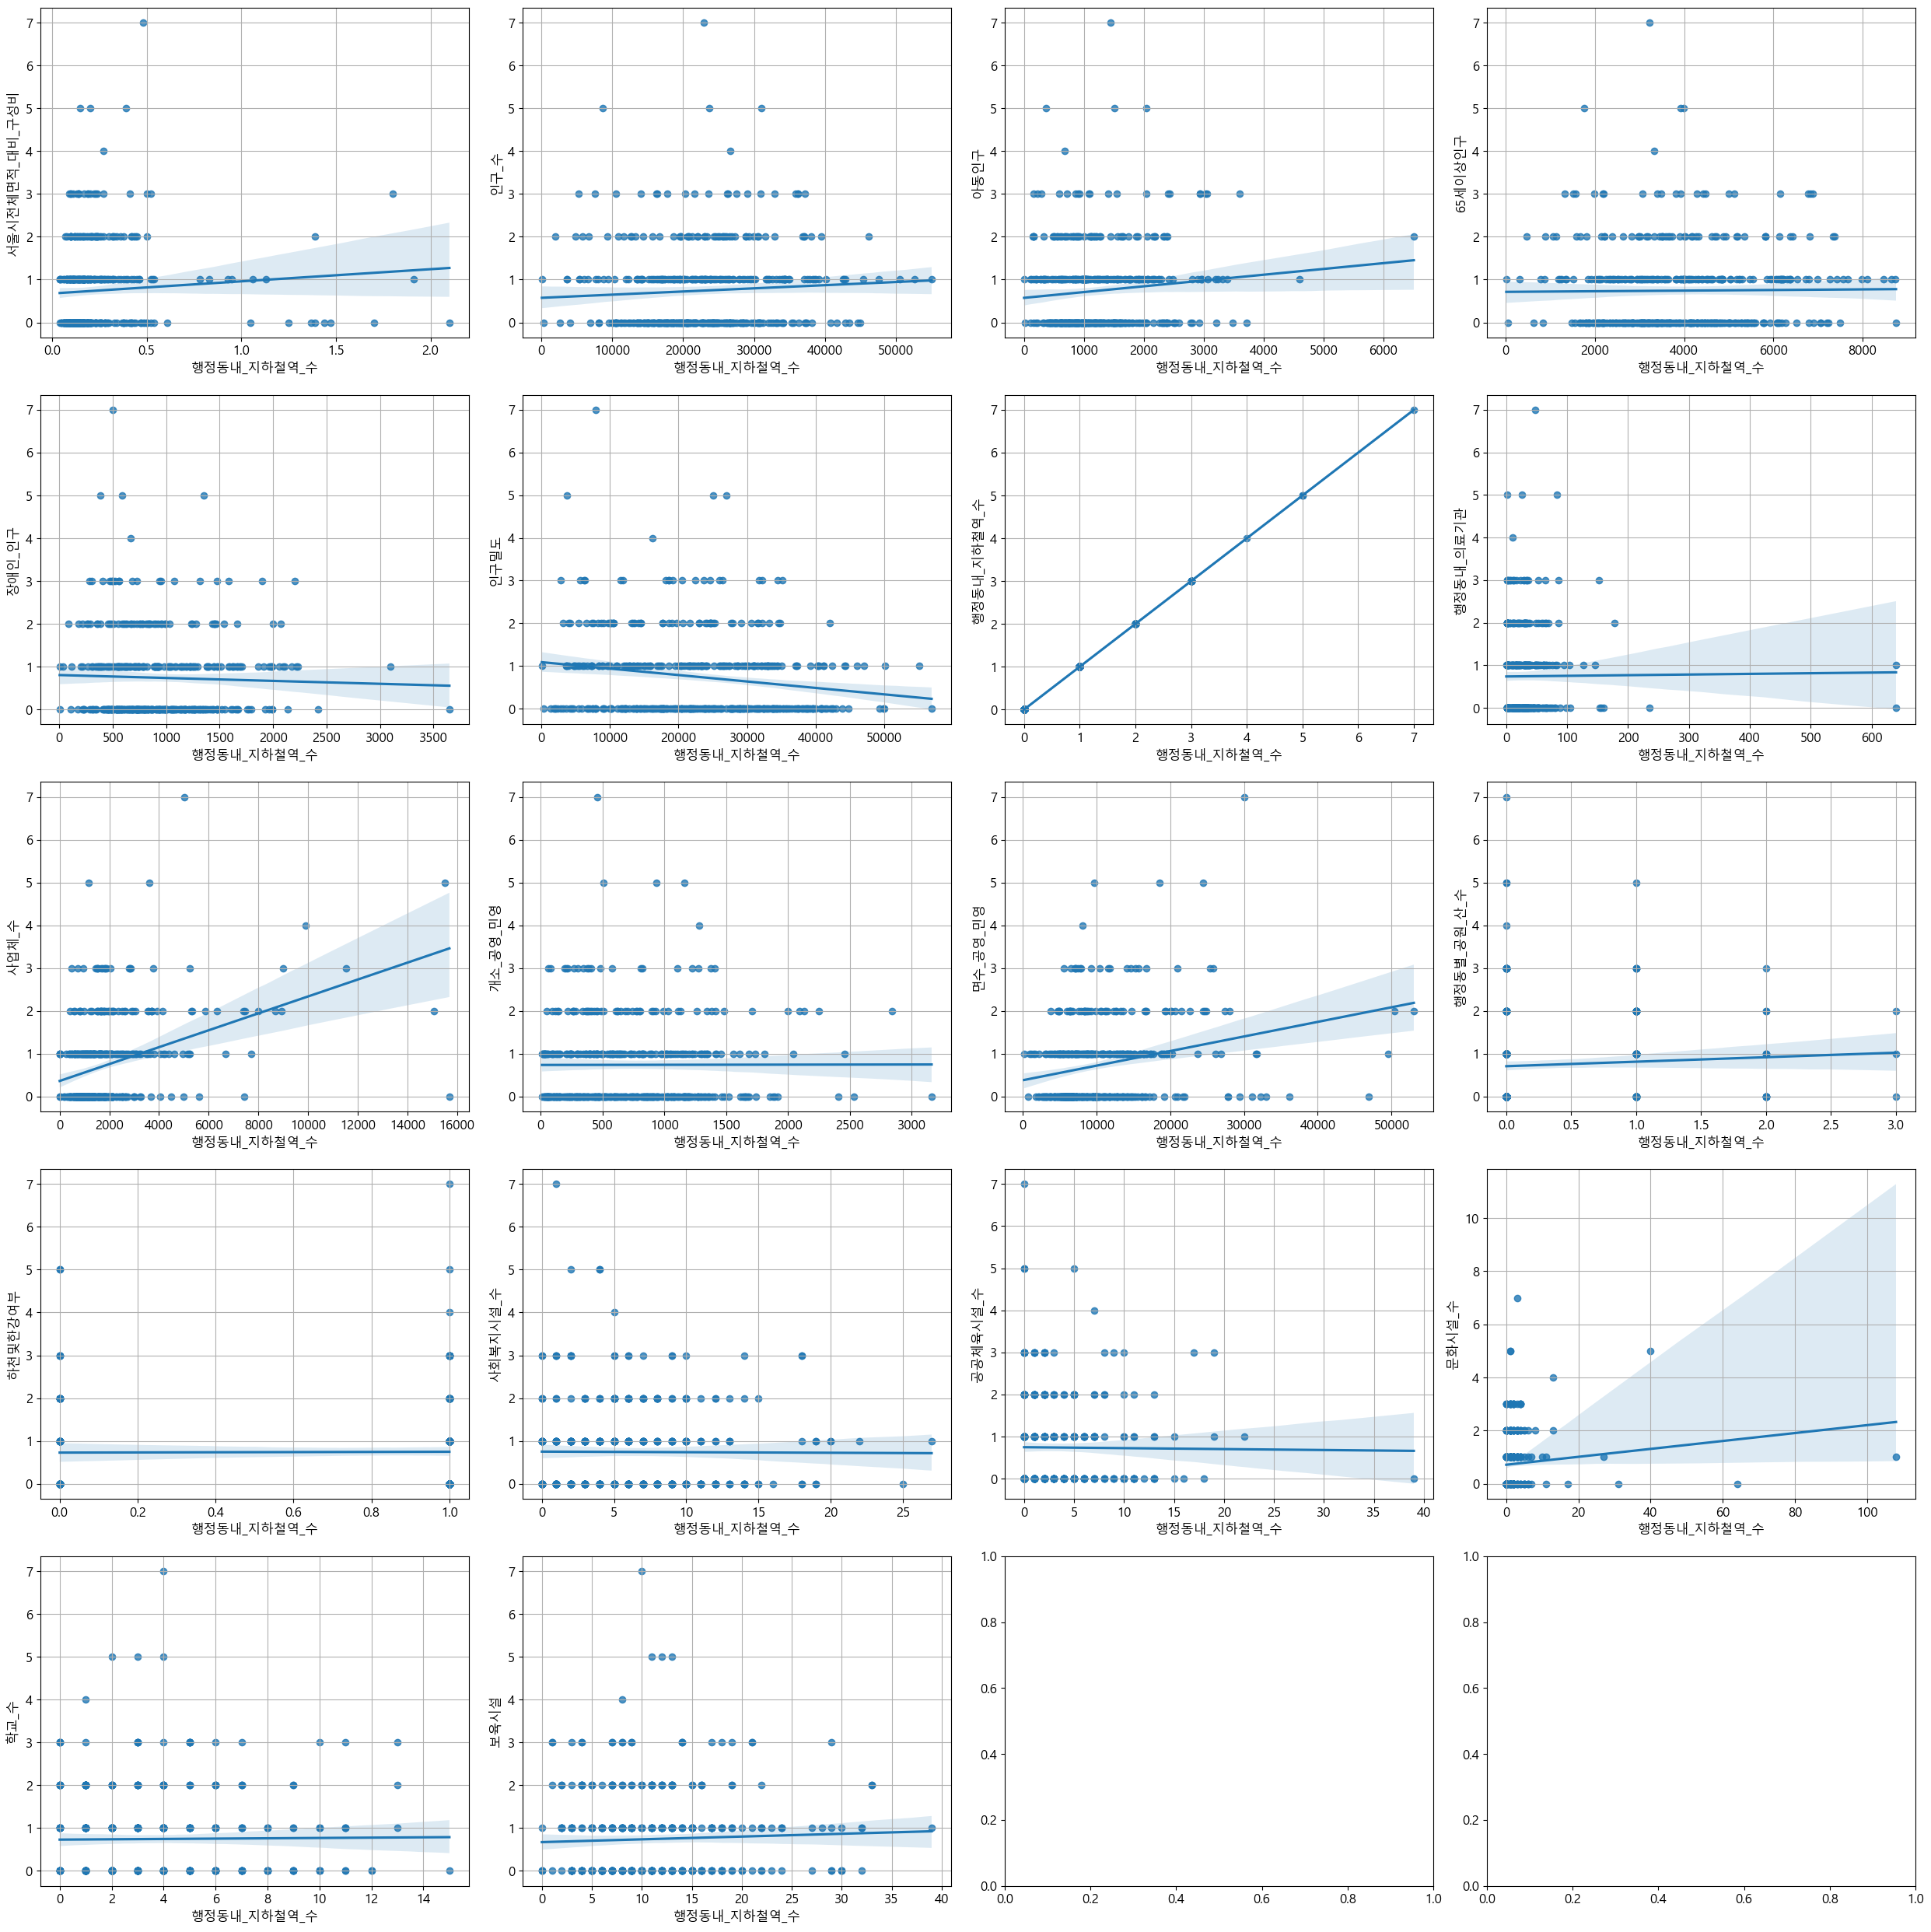

In [12]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리기 때문에 1부터 시작
columns = list(df1.columns)[1:]

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(25, 25))

# 종속변수 설정
dependent_variable = '행정동내_지하철역_수'

for i, c in enumerate(columns):
    row, col = divmod(i, 4)
    sb.regplot(data=df1, y=dependent_variable, x=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    plt.tight_layout() # 그래프 간격 조정
    ax[row, col].grid() # 격자표시

plt.show()
plt.close()

### 반복문과 sub plot을 이용해 boxplot 조회

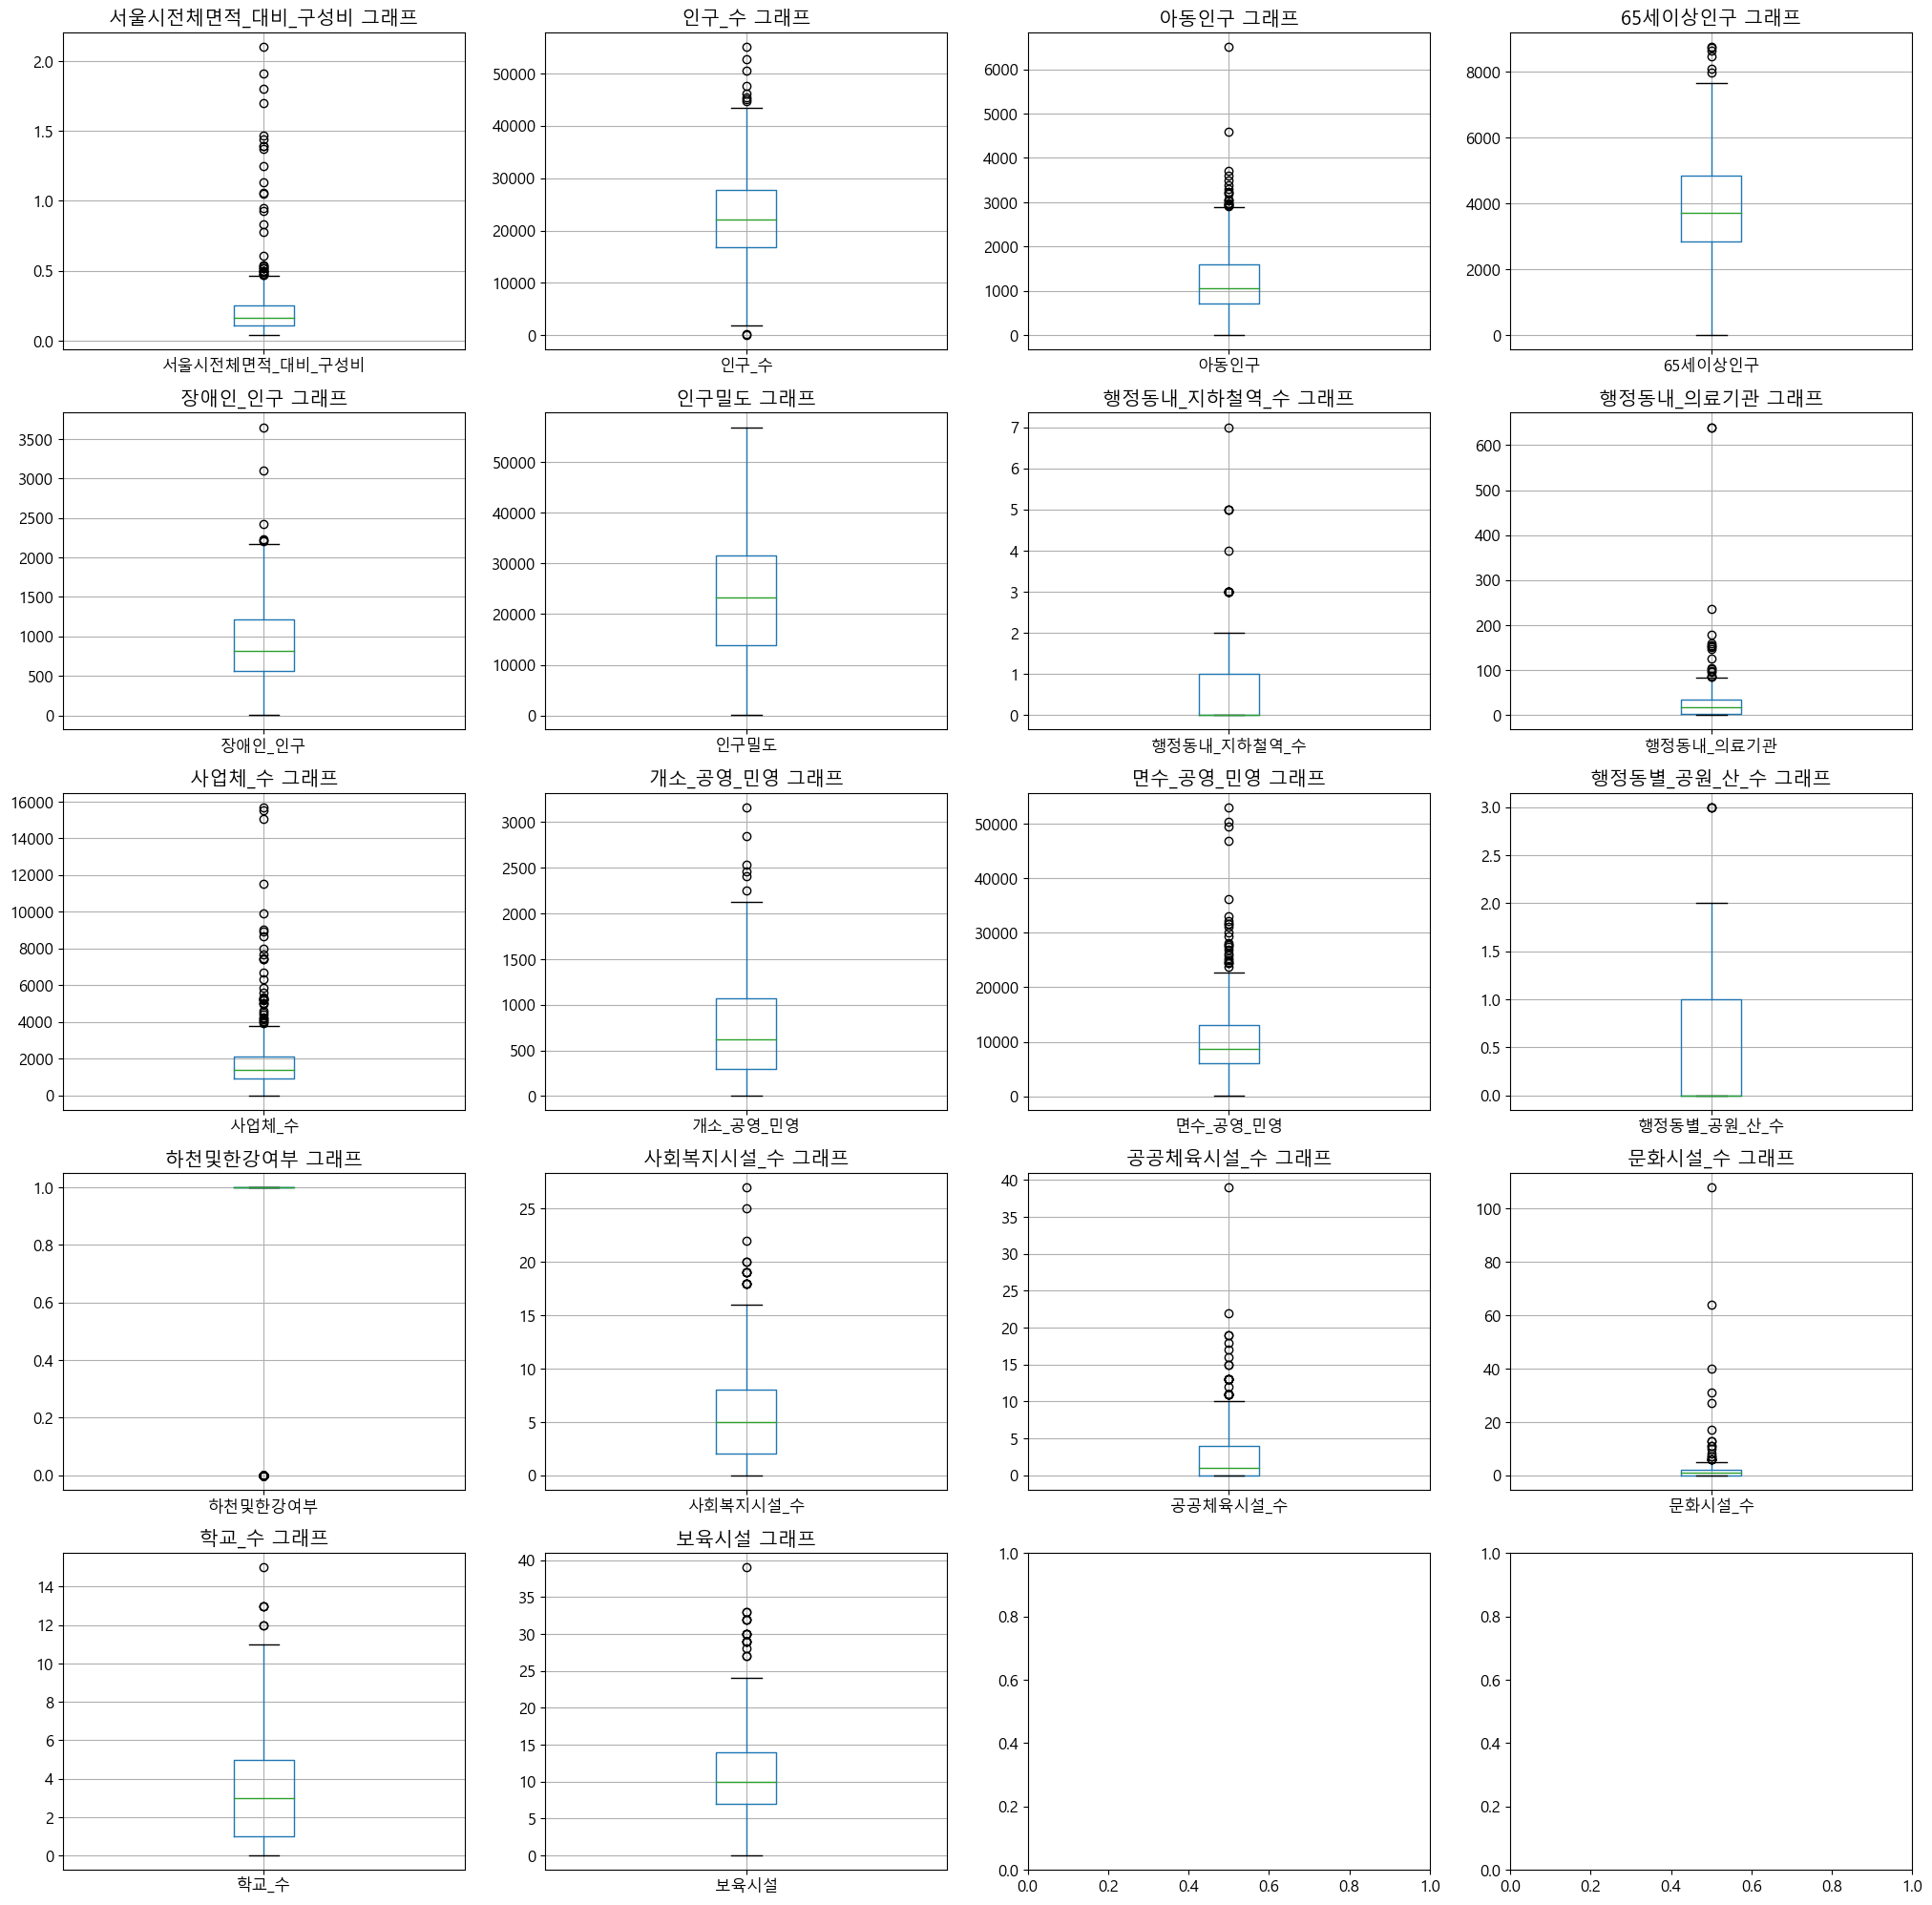

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(25, 25))
for i, c in enumerate(columns):
    row, col = divmod(i, 4)
    df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid()
plt.show()

> 이상치로 의심되는 값이 존재하지만 실제 조사값인 만큼 사용하기로 결정

# 신뢰구간

In [14]:
df1Col = list(df1.columns)
# df1Col
for cc in df1Col:
    print("%s 신뢰구간95%%"%cc)
    helper.getConfidenceInterval(df1["%s"%cc])

면적 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    1.27126 |
| 상한 |    1.57024 |
+------+------------+
서울시전체면적_대비_구성비 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |   0.210114 |
| 상한 |   0.259557 |
+------+------------+
인구_수 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    21839.5 |
| 상한 |    23555.4 |
+------+------------+
아동인구 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    1173.81 |
| 상한 |    1321.18 |
+------+------------+
65세이상인구 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    3762.69 |
| 상한 |    4066.63 |
+------+------------+
장애인_인구 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |    873.239 |
| 상한 |    966.742 |
+------+------------+
인구밀도 신뢰구간95%
+------+------------+
|      |   신뢰구간 |
|------+------------|
| 하한 |      21946 |
| 상한 |    24122.5 |
+------+------------+
행정동내_지하철역_수 신뢰구간95%
+------+

### 신뢰구간 계산

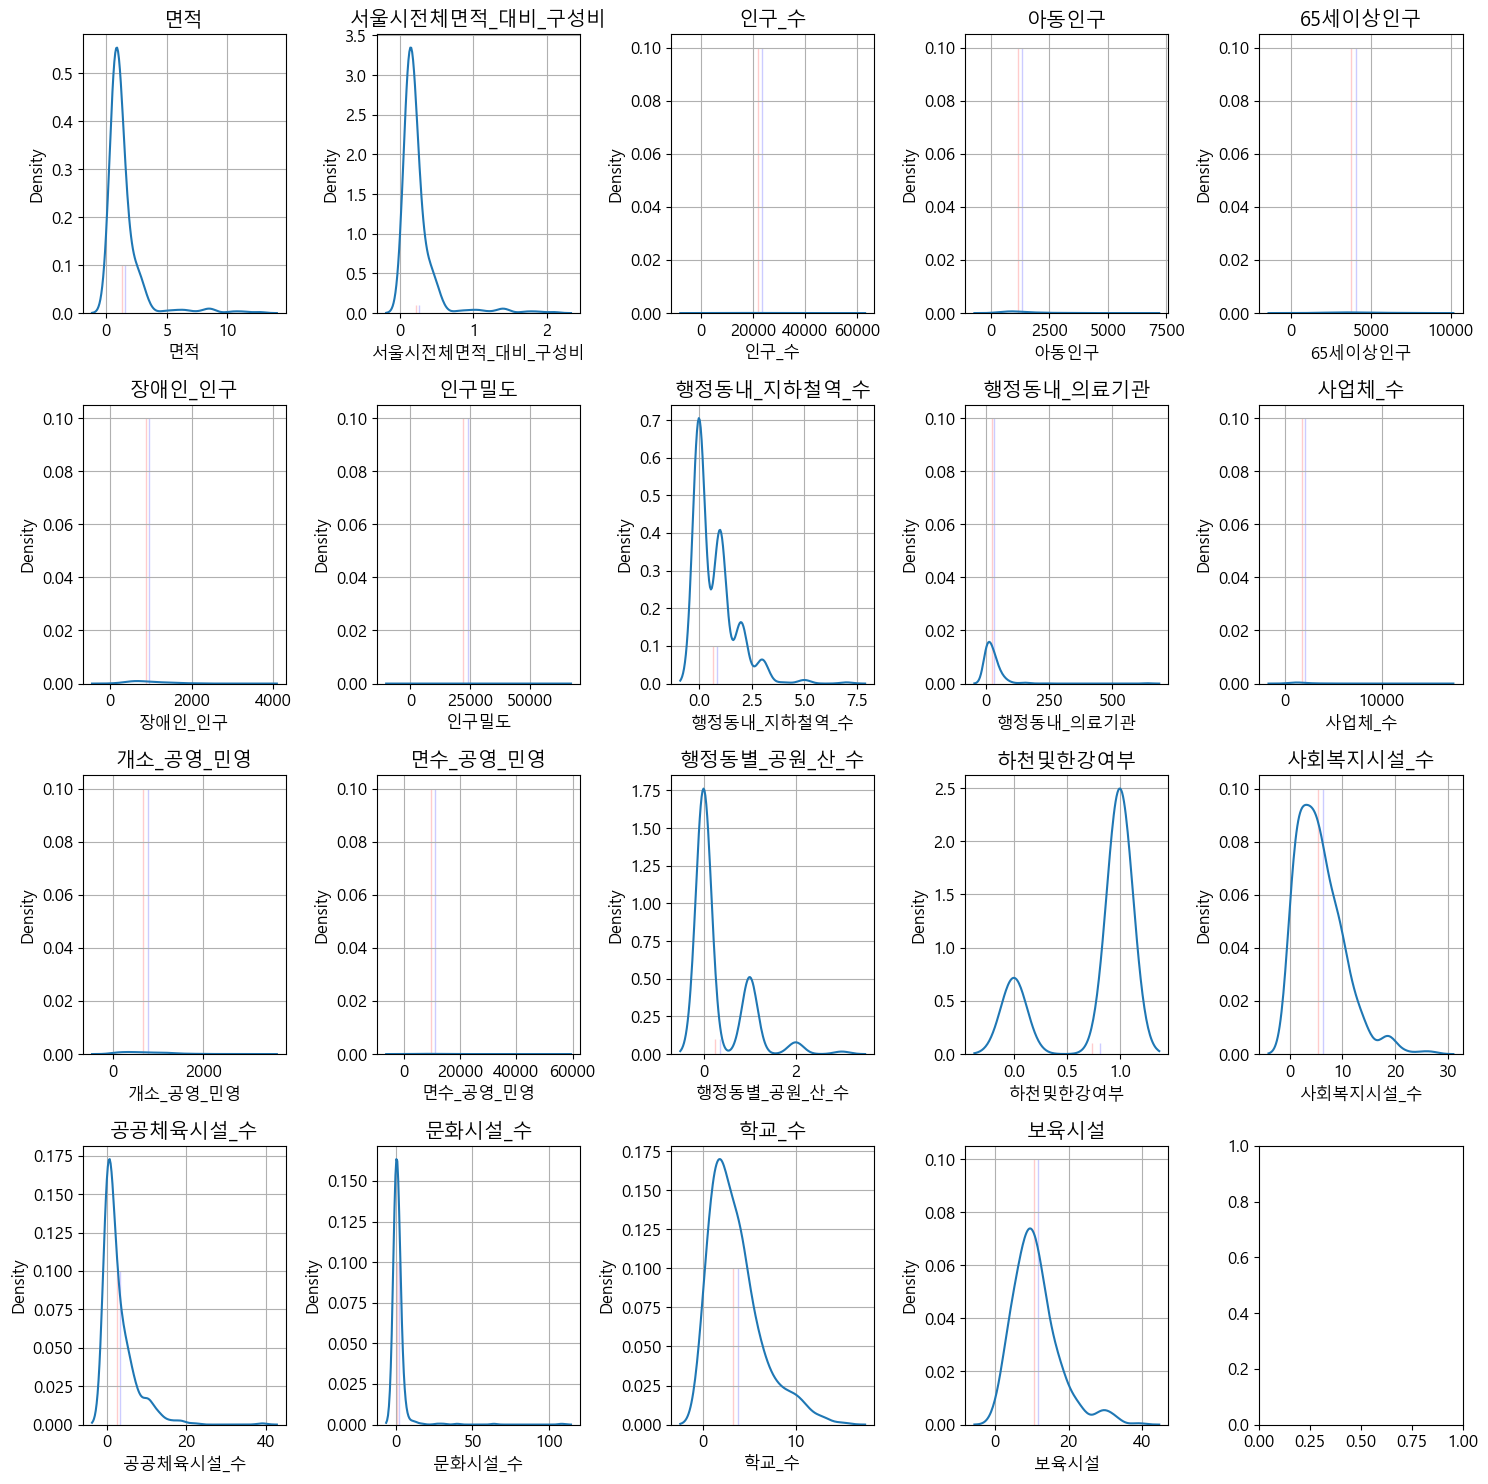

In [14]:
# 변수명 리스트 생성
variables = df1.columns

# 신뢰구간 계산
# 신뢰구간은 95%
confidence_level = 0.95
confidence_intervals = {}  # 각 변수별 신뢰구간을 저장할 딕셔너리

for var in variables:
    sample = df1[var]
    n = len(sample)
    sample_mean = sample.mean()
    sample_std = sample.std(ddof=1)
    std_error = sample_std / sqrt(n)
    
    t_value = t.ppf((1 + confidence_level) / 2, df=n-1)
    margin_of_error = t_value * std_error
    
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    
    confidence_intervals[var] = (lower_bound, upper_bound)

# subplot 설정
# num_rows = (len(variables) + 2) // 3  # 3열로 subplot 배치
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15))

# 신뢰구간 시각화
for ax, var in zip(axes.flat, variables):
    cmin, cmax = confidence_intervals[var]  # 하한과 상한
    
    sb.kdeplot(data=df1, x=var, ax=ax)
    sb.lineplot(x=[cmin, cmin], y=[0, 0.1], color='red', ax=ax)
    sb.lineplot(x=[cmax, cmax], y=[0, 0.1], color='blue', ax=ax)
    ax.set_title(f'{var}')
    # ax.set_xlim(x_ranges[var])  # x축 범위 확장
    # ax.set_ylim(y_ranges[var])  # y축 범위 설정
    ax.grid(True)  # 격자 표시
    plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

## 스피어만 상관분석 및 히트맴

In [15]:
helper.spearman_r(df1)

+-------------------------------------------+-------------+--------------+----------+
| fields                                    |   statistic |       pvalue | result   |
|-------------------------------------------+-------------+--------------+----------|
| 면적 vs 서울시전체면적_대비_구성비        |    0.999183 |            0 | True     |
| 서울시전체면적_대비_구성비 vs 인구_수     |     0.43411 |  5.25702e-21 | True     |
| 인구_수 vs 아동인구                       |    0.747458 |  2.50289e-77 | True     |
| 아동인구 vs 65세이상인구                  |    0.574024 |  1.05461e-38 | True     |
| 65세이상인구 vs 장애인_인구               |    0.873669 | 9.48481e-135 | True     |
| 장애인_인구 vs 인구밀도                   |    0.212592 |  9.61581e-06 | True     |
| 인구밀도 vs 행정동내_지하철역_수          |   -0.163557 |  0.000702231 | True     |
| 행정동내_지하철역_수 vs 행정동내_의료기관 |  0.00409005 |     0.932921 | False    |
| 행정동내_의료기관 vs 사업체_수            |  -0.0649149 |     0.181124 | False    |
| 사업체_수 vs 개소_공영_민영               |     0.47361 |  3.33794e-25 | True     

In [16]:
corr = df1.corr(method='spearman')
# corr.head()

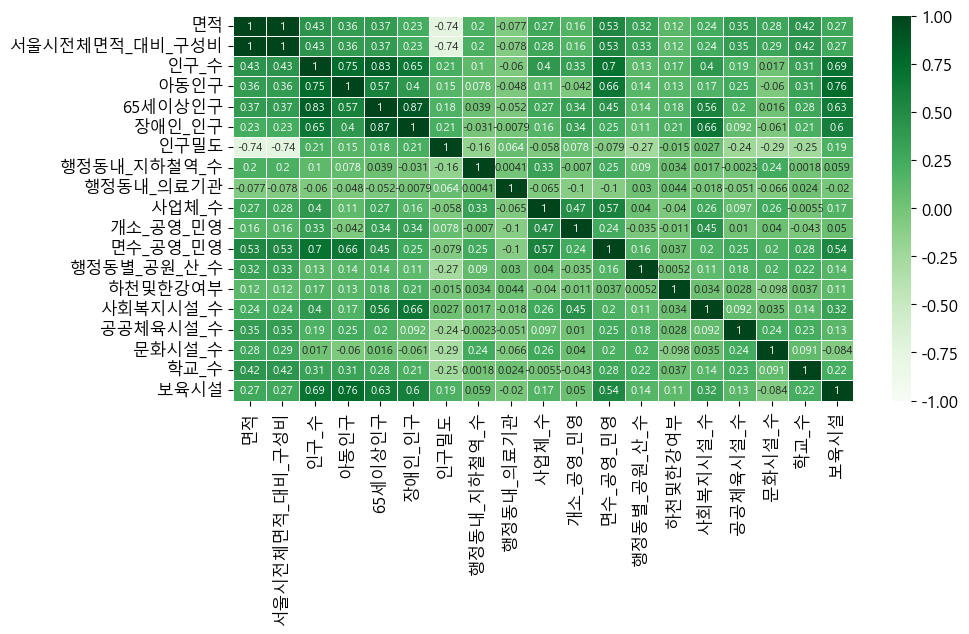

In [17]:
plt.rcParams["figure.figsize"] = (10,5)

sb.heatmap(corr,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Greens', #색상(Greys,Purples,Blues,Greens,Oranges,Reds,OrRd,PuRd,RdPu,BuPu,GnBu,PuBu,YlGnBu,PuBuGn,BuGn,YlGn)
           vmin = -1, vmax=1 , #컬러차트 영역 -1 ~ +1
           linewidths=.5, #구분선 굵기
           annot_kws={"size": 8}  # 글자 크기 조정
)

plt.show()
plt.close()

> 보육시설은 아동의 이용율이 압도적이며, 고령일 수록 사고 확률을 포함한 다양한 변수로 장애를 얻을 확률이 높은 만큼 상관성이 충분히 존재한다고 판단.

> 역세권의 종속변수는 `행정동내_지하철역_수`로 설정 했을 때 종속변수와 상관성이 높은 `사업체_수`와 `문화시설_수`를 사용해 군집화를 진행해 역세권을 추출

## ols 분석

In [18]:
result = helper.myOls(df1, x=df1.columns, y='행정동내_지하철역_수')
result.summary

TypeError: sequence item 0: expected str instance, Index found

## 주성분 분석

In [21]:
cnames = []
dtypes = df1.dtypes

for i, v in enumerate(dtypes):
    if v != 'category':
        print(dtypes.index[i], dtypes[i])
        cnames.append(dtypes.index[i])
        
print(cnames)

면적 float64
서울시전체면적_대비_구성비 float64
인구_수 int64
아동인구 int64
65세이상인구 int64
장애인_인구 int64
인구밀도 float64
행정동내_지하철역_수 int64
행정동내_의료기관 int64
사업체_수 int64
개소_공영_민영 int64
면수_공영_민영 int64
행정동별_공원_산_수 int64
하천및한강여부 int64
사회복지시설_수 int64
공공체육시설_수 int64
문화시설_수 int64
학교_수 int64
보육시설 int64
['면적', '서울시전체면적_대비_구성비', '인구_수', '아동인구', '65세이상인구', '장애인_인구', '인구밀도', '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수', '개소_공영_민영', '면수_공영_민영', '행정동별_공원_산_수', '하천및한강여부', '사회복지시설_수', '공공체육시설_수', '문화시설_수', '학교_수', '보육시설']


In [22]:
# 데이터 정규화-표준화(scaling)
x_train_std_df, y_train_std_df = helper.scalling(df1[cnames], '행정동내_지하철역_수')
x_train_std_df.head()

,면적,서울시전체면적_대비_구성비,인구_수,아동인구,65세이상인구,장애인_인구,인구밀도,행정동내_의료기관,사업체_수,개소_공영_민영,면수_공영_민영,행정동별_공원_산_수,하천및한강여부,사회복지시설_수,공공체육시설_수,문화시설_수,학교_수,보육시설
0,0.732972,0.714129,-1.209019,-0.822284,-1.104595,-0.985005,-1.615171,0.912321,-0.479910,-0.098808,-0.833069,3.004452,-1.866604,-0.173512,1.695537,0.605050,1.621907,-1.111423
1,-0.121658,-0.134352,-1.482731,-0.982732,-1.321667,-1.331701,-1.351705,-0.337982,0.851906,-0.679943,0.284003,4.774710,-1.866604,-1.058733,1.212555,1.630780,-0.535010,-0.009607
2,0.044166,0.058485,-2.228741,-1.474426,-2.063226,-1.651885,-1.862696,-0.474733,-0.628822,-0.716026,-1.161373,1.234194,-1.866604,-1.280038,-0.236389,4.268372,-0.535010,-1.268825
3,0.541637,0.559860,-1.462616,-1.116007,-1.317903,-1.241968,-1.650001,-0.259838,-0.707472,-0.235546,-0.980701,1.234194,0.535732,-0.394817,0.488083,0.458517,0.183962,-1.268825
4,4.751010,4.763698,-0.537799,-0.277539,-0.263284,-0.874878,-1.841656,-0.435661,-0.608373,1.703468,-0.164192,-0.536064,0.535732,1.154320,0.488083,1.337714,0.183962,-1.268825


In [23]:
# # 표준화 결과를 활용하여 주성분 분석 수행
model = pca()
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']
topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [18] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [18] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[13]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,인구_수,0.382019,best
1,PC2,인구밀도,-0.476615,best
2,PC3,사업체_수,0.572786,best
3,PC4,사회복지시설_수,0.468129,best
4,PC5,문화시설_수,0.549370,best
5,PC6,행정동내_의료기관,0.878047,best
6,PC7,하천및한강여부,0.775254,best
7,PC8,학교_수,0.646535,best
8,PC9,공공체육시설_수,-0.544818,best
9,PC10,개소_공영_민영,-0.492770,best


In [24]:
# # 주성분 선정
best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
best_names

['인구_수',
 '인구밀도',
 '사회복지시설_수',
 '하천및한강여부',
 '공공체육시설_수',
 '학교_수',
 '사업체_수',
 '개소_공영_민영',
 '문화시설_수',
 '행정동내_의료기관']

In [25]:
# target_names 변수에 PCA분석을 통한 best값+종속변수를 결합
target_names = best_names + ['행정동내_지하철역_수']
target_names

['인구_수',
 '인구밀도',
 '사회복지시설_수',
 '하천및한강여부',
 '공공체육시설_수',
 '학교_수',
 '사업체_수',
 '개소_공영_민영',
 '문화시설_수',
 '행정동내_의료기관',
 '행정동내_지하철역_수']

In [26]:
merge_df = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
df2 = merge_df.filter(target_names)
df2.head()

,인구_수,인구밀도,사회복지시설_수,하천및한강여부,공공체육시설_수,학교_수,사업체_수,개소_공영_민영,문화시설_수,행정동내_의료기관,행정동내_지하철역_수
0,-1.209019,-1.615171,-0.173512,-1.866604,1.695537,1.621907,-0.479910,-0.098808,0.605050,0.912321,-0.749211
1,-1.482731,-1.351705,-1.058733,-1.866604,1.212555,-0.535010,0.851906,-0.679943,1.630780,-0.337982,1.270813
2,-2.228741,-1.862696,-1.280038,-1.866604,-0.236389,-0.535010,-0.628822,-0.716026,4.268372,-0.474733,-0.749211
3,-1.462616,-1.650001,-0.394817,0.535732,0.488083,0.183962,-0.707472,-0.235546,0.458517,-0.259838,-0.749211
4,-0.537799,-1.841656,1.154320,0.535732,0.488083,0.183962,-0.608373,1.703468,1.337714,-0.435661,-0.749211
